In [313]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(8,5)})
sns.set_style("white", {'font.family':'serif', 'font.serif':'Times Roman'})
sns.set_context("talk")
sns.set_palette("crest")

In [128]:
import pandas as pd

# Contents:

* Summary stats on transcription duration (episode level) and transcription proportion (vs. metadata duration)
* Sentence BERT embedding EDA

##  I. What proportion of the podcast episode duration is transcribed?

### Data scraping/download

In [55]:
TRANSCRIPT_DIRECTORY = '../podcasts-no-audio-13GB/spotify-podcasts-2020/podcasts-transcripts/'

In [87]:
def get_transcript_metadata(json_filepath):
    """For a single transcript json, 
    get lists of all transcript segment durations and word counts"""
    durations = []; num_words = []
    tt = Transcript(json_filepath, segment_definition = 'default')
    for idx, (start, end) in enumerate(tt.data['text_chunks_times']):
        durations.append(end - start)
        num_words.append(len(tt.data['text_chunks'][idx]))
    return durations, num_words
    #total_duration = np.sum(np.array(durations))

In [103]:
import os
from tqdm import tqdm
import pickle

def gather_transcript_metadata(root_directory):
    """
    Return dictionary with keys ('filepath'), i.e. the filepath to transcript json
    values: dictionary with keys ('duration', 'num_words'): 
        values are lists of all transcript segment duration and word counts
    """
    num_files = 0
    num_success_files = 0

    corpus_info = {}
    rootDir = TRANSCRIPT_DIRECTORY

    for i in tqdm(os.listdir(rootDir)):
        current_dir = rootDir + i + '/' 
        for dirName, subdirList, fileList in os.walk(current_dir):
            for fname in fileList:
                if '.json' in fname:
                    num_files += 1
                    file_path = os.path.join(dirName, fname)
                    durations, num_words = get_transcript_metadata(file_path)
                    corpus_info[file_path] = {}
                    corpus_info[file_path]['durations'] = durations
                    corpus_info[file_path]['num_words'] = num_words
                    num_success_files += 1
    print('total files: ',num_files)
    print('total successful: ',num_success_files)
    return corpus_info

In [104]:
corpus_info = gather_transcript_metadata(TRANSCRIPT_DIRECTORY)

100%|██████████| 8/8 [20:02<00:00, 150.34s/it]

total files:  105360
total successful:  105360


In [107]:
with open('corpus_info.pickle', 'wb') as handle:
    pickle.dump(corpus_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Data summarization

In [ ]:
with open('corpus_info.pickle', 'rb') as handle:
    corpus_info = pickle.load(handle)

In [232]:
transcribed_durations = [np.sum(np.array(corpus_info[e]['durations'])) for e in corpus_info]
transcribed_words = [np.sum(np.array(corpus_info[e]['num_words'])) for e in corpus_info]

#### Descriptive statistics on transcribed durations

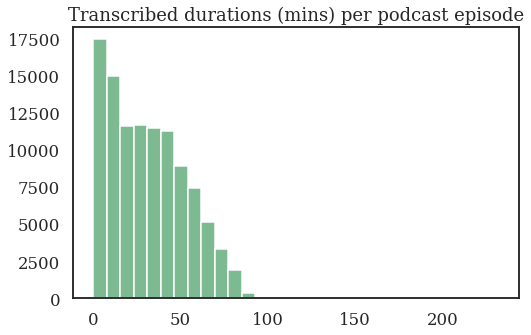

In [314]:
plt.hist(np.array(transcribed_durations)/60, bins = 30)
plt.title("Transcribed durations (mins) per podcast episode");

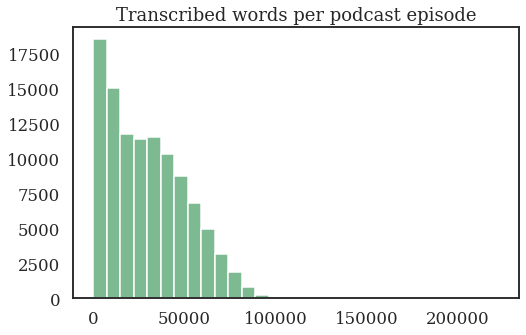

In [315]:
plt.hist(transcribed_words, bins = 30)
plt.title("Transcribed words per podcast episode");

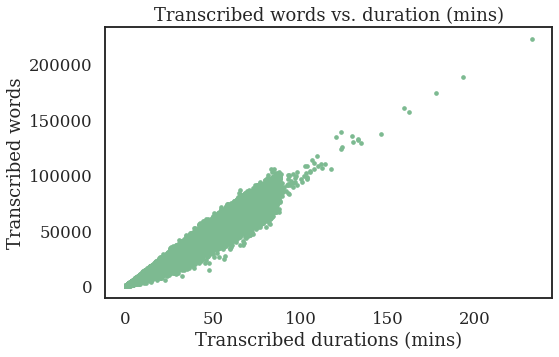

In [316]:
plt.scatter(np.array(transcribed_durations)/60, transcribed_words, s=10)
plt.xlabel("Transcribed durations (mins)")
plt.ylabel("Transcribed words")
plt.title("Transcribed words vs. duration (mins)");

In [317]:
# Summary, in minutes
(pd.DataFrame(total_durations)/60).describe()

,0
count,105360.000000
mean,31.379448
std,21.625049
min,0.058333
25%,12.028333
50%,29.055000
75%,47.055417
max,232.240000


In [318]:
# Segment level EDA (rather than podcast episode level)
transcribed_segment_durations = []
transcribed_segment_words = []

for e in corpus_info:
    transcribed_segment_durations.extend(corpus_info[e]['durations'])
    transcribed_segment_words.extend(corpus_info[e]['num_words'])

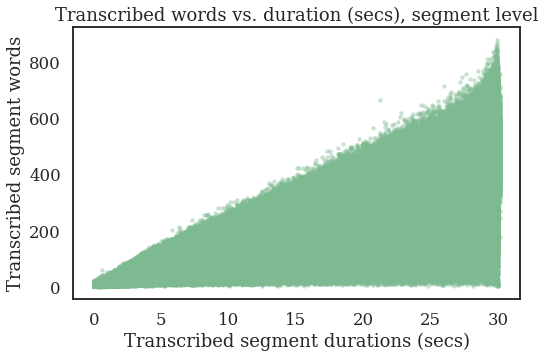

In [320]:
plt.scatter(transcribed_segment_durations, transcribed_segment_words, s=10, alpha = 0.3)
plt.xlabel("Transcribed segment durations (secs)")
plt.ylabel("Transcribed segment words")
plt.title("Transcribed words vs. duration (secs), segment level");

In [321]:
print(f"Number of segment durations in all transcripts: {len(transcribed_segment_durations)}")

Number of segment durations in all transcripts: 8429540


#### Transcribed duration proportion (using duration from metadata.tsv)

In [322]:
summary_df = pd.DataFrame()

In [323]:
summary_df['transcribed_duration'] = transcribed_durations
summary_df['transcribed_words'] = transcribed_words
summary_df.index = corpus_info.keys()

In [324]:
summary_df['show_id'] = summary_df.index.str.split('/').str[-2].str.replace('show_', '')
summary_df['episode_id'] = summary_df.index.str.split('/').str[-1].str.replace(r'\.json', '', regex=True)
summary_df.reset_index(drop = True, inplace = True)
summary_df.head()

,transcribed_duration,transcribed_words,show_id,episode_id
0,1167.0,19808,3vmNgKtF08qGibwutrRSuu,3txQtgG2gW7FwNFhCjUYcK
1,2584.1,40435,3V7ZvqWMfT1urrt3OhO9xY,1hXbUDak2nEjST8b9Ib1Ul
2,1690.6,24421,3vZ8IRAthqKH80u3BT4Qe2,5AEQ30rSZpntk81oCSHRDX
3,1572.9,28452,3v1yJUJtcxzpW1b2YC3epN,53DdXPaeiEtFxB8coOpzyN
4,2174.4,39283,3v1yJUJtcxzpW1b2YC3epN,75S6UxqGE3wI0boOhTsoZD


In [325]:
episode_metadata_df = pd.read_csv('../podcasts-no-audio-13GB/metadata.tsv', sep ='\t')
episode_metadata_df['show_id'] = episode_metadata_df['show_uri'].str.replace('spotify:show:', '')
episode_metadata_df['episode_id'] = episode_metadata_df['episode_uri'].str.replace('spotify:episode:', '')
episode_metadata_df[['duration', 'show_id', 'episode_id']].head()

,duration,show_id,episode_id
0,12.700133,2NYtxEZyYelR6RMKmjfPLB,000A9sRBYdVh66csG2qEdj
1,6.019383,15iWCbU7QoO23EndPEO6aN,000HP8n3hNIfglT2wSI2cA
2,43.616333,6vZRgUFTYwbAA79UNCADr4,001UfOruzkA3Bn1SPjcdfa
3,58.189200,5BvKEjaMSuvUsGROGi2S7s,001i89SvIQgDuuyC53hfBm
4,51.782050,7w3h3umpH74veEJcbE6xf4,0025RWNwe2lnp6HcnfzwzG


In [326]:
print(f"Shape of episode metadata df:\t\t\t\t{episode_metadata_df.shape}")
print(f"Shape of duration df (constructed from transcripts):\t{summary_df.shape}")

Shape of episode metadata df:				(105360, 14)
Shape of duration df (constructed from transcripts):	(105360, 4)


In [327]:
# All episode id, show id are shared between the two dataframes
len(set(summary_df['show_id']+summary_df['episode_id']).intersection(
    set(episode_metadata_df['show_id']+episode_metadata_df['episode_id'])
))

105360

In [328]:
merged_df = pd.merge(summary_df, episode_metadata_df, how = 'inner', on = ['show_id', 'episode_id'])

In [329]:
merged_df.columns

Index(['transcribed_duration', 'transcribed_words', 'show_id', 'episode_id',
       'show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix'],
      dtype='object')

In [330]:
merged_df['transcribed_duration_mins'] = merged_df['transcribed_duration']/60.

In [331]:
merged_df['transcribed_proportion'] = merged_df['transcribed_duration_mins'] / merged_df['duration']

In [332]:
pd.DataFrame(merged_df['transcribed_proportion']).describe()

,transcribed_proportion
count,105360.000000
mean,0.920910
std,0.283829
min,0.002720
25%,0.916316
50%,0.955712
75%,0.973459
max,84.925029


In [333]:
# These are unexpected; looks like duration from metadata file may not be accurate
merged_df[merged_df['transcribed_proportion']>1].head()

,transcribed_duration,transcribed_words,show_id,episode_id,show_uri,show_name,show_description,publisher,language,rss_link,episode_uri,episode_name,episode_description,duration,show_filename_prefix,episode_filename_prefix,transcribed_duration_mins,transcribed_proportion
890,140.9,1865,3yKJwISi5ajbAGZLw8IaJy,7Lx1iV0j2N8IAtx7Vc9s6f,spotify:show:3yKJwISi5ajbAGZLw8IaJy,Rosé and Thorns: A Bachelor Podcast,A comedy podcast about the greatest franchise ...,Martin P,['en'],https://anchor.fm/s/121439c8/podcast/rss,spotify:episode:7Lx1iV0j2N8IAtx7Vc9s6f,Trailer,"Hey Bachelor Nation, we are the new Bachelor P...",0.781250,show_3yKJwISi5ajbAGZLw8IaJy,7Lx1iV0j2N8IAtx7Vc9s6f,2.348333,3.005867
1806,4831.3,77573,3o02a6CRTu9dXFpf5gzkfG,09C37MMWT1MJ34YhNKAQkZ,spotify:show:3o02a6CRTu9dXFpf5gzkfG,BrewsBeats&Eats The Podcast,Welcome to BrewsBeats&Eats w/Oldhead Ed. Where...,BrewsBeats&Eats,['en'],https://anchor.fm/s/2cdafbc/podcast/rss,spotify:episode:09C37MMWT1MJ34YhNKAQkZ,Pa' lo' activao Ft. Mamajuana King,Welcome to BrewsBeats&Eats w/Oldhead Ed. This ...,0.948150,show_3o02a6CRTu9dXFpf5gzkfG,09C37MMWT1MJ34YhNKAQkZ,80.521667,84.925029
3890,69.9,966,3j3GybU9u03zLYqLUOSfPB,3DueoXkp1t5naecPW9uJJ3,spotify:show:3j3GybU9u03zLYqLUOSfPB,Parcast Presents: March Mysteries,"More times than not, life's greatest mysteries...",Parcast Network,['en'],https://feeds.megaphone.fm/SPOT4938274129,spotify:episode:3DueoXkp1t5naecPW9uJJ3,Welcome to March Mysteries!,"More times than not, life's greatest mysteries...",0.957817,show_3j3GybU9u03zLYqLUOSfPB,3DueoXkp1t5naecPW9uJJ3,1.165000,1.216308
4522,285.6,5177,3xvYJyx5HbivSix23Rf9Sl,3MfSAwlvjc3P0eRbQAOwwq,spotify:show:3xvYJyx5HbivSix23Rf9Sl,Avenues Parent Podcast,The Avenues Parent Podcast is your source for ...,Avenues Parent Podcast,['en'],https://anchor.fm/s/106f7754/podcast/rss,spotify:episode:3MfSAwlvjc3P0eRbQAOwwq,#3 [ENG]: Self-reporting and self-assessment,"In our third episode, we discuss self-reportin...",4.548800,show_3xvYJyx5HbivSix23Rf9Sl,3MfSAwlvjc3P0eRbQAOwwq,4.760000,1.046430
5084,147.1,2702,3LDzLEOfufz1YTf1pVVn9t,4IjrRNZ9ac7GU1K9fVUD8I,spotify:show:3LDzLEOfufz1YTf1pVVn9t,Daily Self-Improvement Habits,"In Daily Self-Improvement Habits, we make deep...",Nick Colo,['en'],https://anchor.fm/s/b1c24c8/podcast/rss,spotify:episode:4IjrRNZ9ac7GU1K9fVUD8I,#11 Take 1 Step Daily,Reaching your goals is all about taking small ...,2.070633,show_3LDzLEOfufz1YTf1pVVn9t,4IjrRNZ9ac7GU1K9fVUD8I,2.451667,1.184018


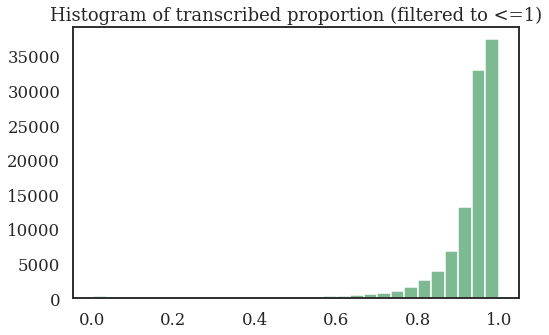

In [334]:
plt.hist(merged_df[merged_df['transcribed_proportion']<=1]['transcribed_proportion'], bins = 30)
plt.title("Histogram of transcribed proportion (filtered to <=1)");

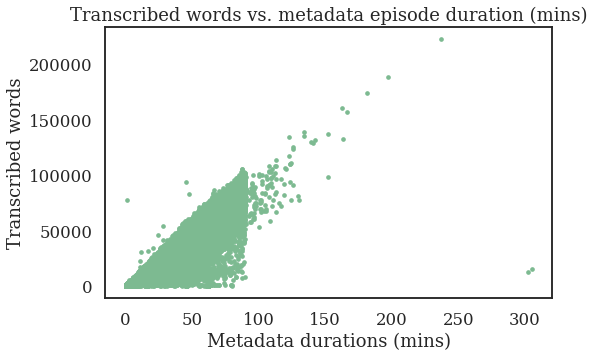

In [335]:
plt.scatter(merged_df['duration'], merged_df['transcribed_words'], s=10)
plt.xlabel("Metadata durations (mins)")
plt.ylabel("Transcribed words")
plt.title("Transcribed words vs. metadata episode duration (mins)");

## II. SentenceBERT contextualized embedding EDA

Reference: https://www.sbert.net/

Paper: https://arxiv.org/pdf/1908.10084.pdf

### Getting familiar with sentence_transformers package

In [342]:
## Test code, adapted from the tutorial at https://www.sbert.net/docs/usage/semantic_textual_similarity.html

from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2', device = 'cuda')

#Our sentences we like to encode
sentences = ["Well, first of all, I think you're being facetious and self-contradictory",
    "Totally, I 100% agree with you",
    "You're wrong"]

#Compute embeddings
embeddings = model.encode(sentences, convert_to_tensor=True)

#Compute cosine-similarities for each sentence with each other sentence
cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)

#Find the pairs with the highest cosine similarity scores
pairs = []
for i in range(len(cosine_scores)-1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

#Sort scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

for pair in pairs[0:10]:
    i, j = pair['index']
    print("{} \t {} \t\t Score: {:.4f}".format(sentences[i], sentences[j], pair['score']))

Well, first of all, I think you're being facetious and self-contradictory 	 You're wrong 		 Score: 0.3541
Well, first of all, I think you're being facetious and self-contradictory 	 Totally, I 100% agree with you 		 Score: 0.3463
Totally, I 100% agree with you 	 You're wrong 		 Score: 0.3003


In [346]:
embeddings.shape

torch.Size([3, 384])

### Application to example json (dog disagreement segment)

In [344]:
EXAMPLE_JSON_FILEPATH = TRANSCRIPT_DIRECTORY + '4/9/show_49NxrBHUtto19pgLNAJkHY/6hoNS9LR1Lxb4EzMX72kXR.json'
example_transcript = Transcript(EXAMPLE_JSON_FILEPATH, segment_definition = 'default')

In [364]:
class SBERTVectorizer:
    def __init__(self, model):
        self.model = model
    
    def vectorize(self, segment_text_list):
        """
        Given a list of text segments, return:
            segment_vectors: a np array of np arrays (each entry is the embedding for each segment)
            filter_mask: None
        """
        return self.model.encode(segment_text_list), np.ones(len(segment_text_list))

In [365]:
sbert_vectorizer = SBERTVectorizer(model)

In [366]:
example_transcript = Transcript(EXAMPLE_JSON_FILEPATH, segment_definition = 'default')
example_transcript.set_segment_vectors(sbert_vectorizer)

In [367]:
example_transcript.segment_vectors.shape

(105, 384)

In [416]:
## Temporary solution: eventually import these from Annotation class

def plot_annotations(compiled_annotations_df, episode_id, annotator_colors, font_size = '12'):
    """Plot timeline, filtering df to episode_id; plot params are annotator_colors, y_step"""
    df = compiled_annotations_df[compiled_annotations_df['text'] == episode_id]
    plt.figure(figsize=(20,5))
    plt.rcParams['font.size'] = font_size
    for i, annotator in enumerate(annotator_colors):
        i_df = df[df['annotator'] == annotator]
        for (start,end) in i_df[['start', 'end']].values:
            plt.plot([start/60, end/60], [i, i], 
                     marker = '|', 
                     color = annotator_colors[annotator], 
                     linewidth = 30, markersize = 50, solid_capstyle="butt")
    plt.xlabel("Minute")
    plt.title(f"Annotations for episode: {episode_id}")
    plt.ylim(-1, len(annotator_colors))
    plt.yticks(range(len(annotator_colors)), annotator_colors)

# Tuple union algorithm, modified from https://stackoverflow.com/questions/1034802/union-of-intervals
class tp():
    def __repr__(self):
        return '(%.2f,%.2f)' % (self.start, self.end)
    def __init__(self,start,end): 
        self.start=start
        self.end=end
    def __contains__(self, key):
        if isinstance(key, tp):
            return ((key.start in self) or (key.end in self)) or ((self.start in key) or (self.end in key))
        else:
            return (self.start <= key) and (key <= self.end)
        
def get_union(annot_df, episode_id):
    # filter to episode ID
    annot_df = annot_df[annot_df['text']==episode_id]
    ranges = [tp(s,e) for (s,e) in zip(annot_df['start'], annot_df['end'])]

    s = ranges
    s.sort(key=lambda self: self.start)
    union = [s[0]]
    for x in s[1:]:
        if union[-1].end < x.start:
            union.append(x)
        elif union[-1].end == x.start:
            union[-1].end = x.end
        if x.end > union[-1].end:
            union[-1].end = x.end
    return union

In [417]:
# Compiled annotations pickle file, generated from compile_annotations.py script
ANNOTATIONS_FILEPATH = '../audio_annotation/compiled_annotations_df.pkl'
EPISODE_ID = '6hoNS9LR1Lxb4EzMX72kXR'

annot_df = pd.read_pickle(ANNOTATIONS_FILEPATH)
union_ranges = get_union(annot_df, EPISODE_ID)
union_df = pd.DataFrame([['union', EPISODE_ID, 'DISAGREE', i.start, i.end] for i in union_ranges], 
                        columns = annot_df.columns)

In [418]:
union_df.head()

,annotator,text,label,start,end
0,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,2408.653260,2410.253415
1,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,2414.367289,2418.004163
2,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,2428.312520,2430.462509
3,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,2431.612503,2434.062490
4,union,6hoNS9LR1Lxb4EzMX72kXR,DISAGREE,2443.356610,2446.862424


In [415]:
union_ranges[:5]

[(2408.65,2410.25),
 (2414.37,2418.00),
 (2428.31,2430.46),
 (2431.61,2434.06),
 (2443.36,2446.86)]

In [422]:
example_text_times = [tp(i[0], i[1]) for i in example_transcript.data['text_chunks_times']]
example_text_times[:5]

[(36.50,59.60),
 (60.20,89.80),
 (89.90,119.80),
 (120.00,149.80),
 (149.90,179.80)]

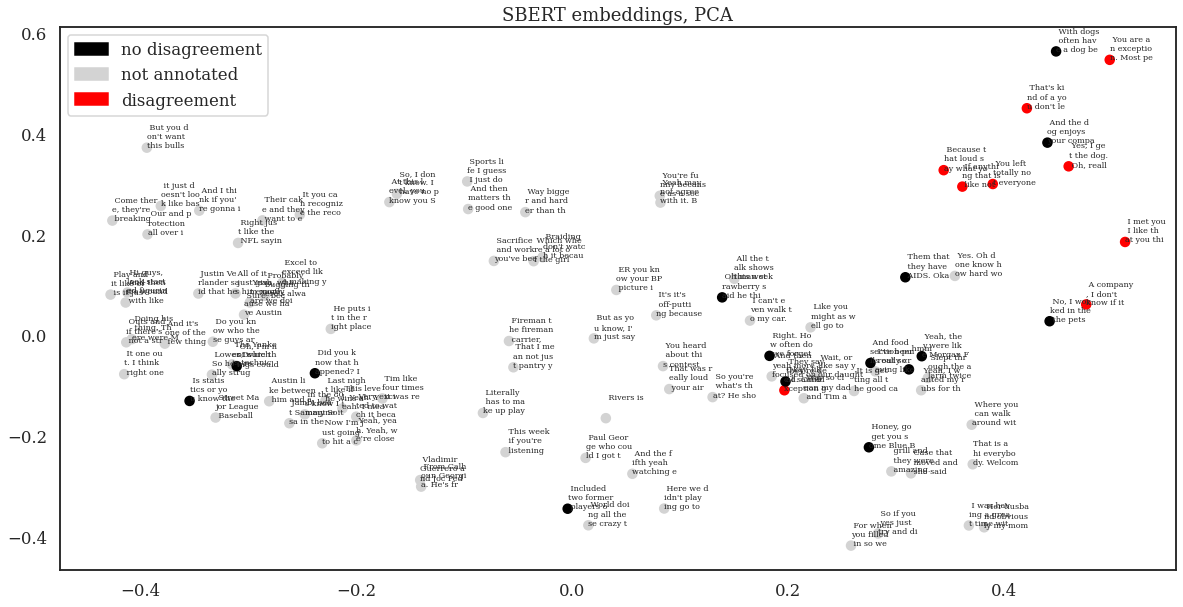

In [427]:
# 1 if disagreement
disagreement_labels = 1*np.array([any([t in r for r in union_ranges]) for t in example_text_times])

# 1 if we annotated the time period (we looked at minute 40 onwards)
annotated_mask = 1*(np.array([i.start for i in example_text_times]) > (60*40))

labels = []

for i in range(len(disagreement_labels)):
    # listened to the clip, but didn't annotate as disagreement
    if (disagreement_labels[i]==0 and annotated_mask[i]==1):
        labels.append(0)
    # didn't listen to the clip
    elif annotated_mask[i]==0:
        labels.append(1)
    # listened and annotated as disagreement
    elif (disagreement_labels[i]==1 and annotated_mask[i]==1):
        labels.append(2)

        
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

pca = PCA(n_components=2)
X = pca.fit_transform(example_transcript.segment_vectors)
plt.figure(figsize = (20,10))
plt.scatter(X[:,0], X[:,1], c = np.array(['black', 'lightgray', 'red'])[labels])

black_patch = mpatches.Patch(color='black', label='no disagreement')
gray_patch = mpatches.Patch(color='lightgray', label='not annotated')
red_patch = mpatches.Patch(color='red', label='disagreement')
plt.legend(handles=[black_patch, gray_patch, red_patch])
plt.title('SBERT embeddings, PCA');

for i, txt in enumerate(example_transcript.data['text_chunks']):
    plt.annotate('\n'.join([txt[:30][i:i+10] for i in range(0, 30, 10)]), 
                 (X[:,0][i], X[:,1][i]), fontsize = 8)

In [443]:
# Manually annotated disagreement examples
np.array(example_transcript.data['text_chunks'])[disagreement_labels.astype(bool)]

array([" Yes, I get the dog. Oh, really? Wow, you were not a dog person until like a year ago. And is that is such a false narrative about me. We got wait a family dog for 10 years when you met Maverick you were like, I'm you told me that have me having a dog was a deal breaker. Yeah, because single girls with dogs, I have a major issue and what's your issue? This is for another time though. It's not is the perfect time single girls.",
       " If anything that is like not slightly Gary, you know that I'm right they keep a dog in this little tiny ass apartment. They never take it for walks because they're alone and can't find a boyfriend. It's not the dog's fault. You're a fucking loser. That is not first of all, are you are you saying? That's what I am. No, you're just laughing because he knows it's true. No, it's just the most ridiculous tape.",
       " You left totally not everyone out. There is agreeing with me. They're in my tweet me at Chris Braman and tell me you agree with me 